In [1]:
import os
import sys
import numpy as np
import pandas as pd
from itertools import product
from datetime import datetime
from talib import RSI
from multiprocessing import Pool, cpu_count
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import pyfolio as pf
import warnings
from time import time, sleep

warnings.filterwarnings('ignore')

# To display multiple outputs from the same cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 100)
pd.set_option('display.min_rows', 100)
pd.set_option('max_colwidth', 400)
pd.set_option('expand_frame_repr', False)


%matplotlib inline
!python -V

Python 3.8.10


/home/solidsnake/epat/assignments/venv/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


### Q1: Backtest a strategy using three moving averages on any indices such as Nifty50, SPY, HSI and so on. ###
1. Compute three moving averages of 20, 40, and 80.
2. Go long when the price crosses above all three moving averages.
3. Exit the long position when the price crosses below any of the three moving averages.
4. Go short when the price crosses below all three moving averages.
5. Exit the short position when the price crosses above any of the three moving averages.
6. Optional: Optimise all three moving averages

In [2]:
asset= "SPY"
start_date = datetime(2020, 2, 1)
end_date = datetime(2022, 6, 30)
def download_data(ticker, start = start_date, end = end_date):
    """ 
    The function downloads daily market data to a pandas DataFrame 
    using the 'yfinance' API between the dates specified. If dates are not specified
    they default from 2015 up until now. Then, It prints different metrics
    """
    data = yf.download(ticker, start, end)
    #signals:
    print(data.tail())
    print(data.shape)
    print(data.isna().sum())
    print(f"shape with NaN values: {data.shape}")
    data.dropna(inplace=True)
    print(f"shape after deleting NaN values: {data.shape}")

    return data

In [3]:
raw_data = download_data(asset, start_date, end_date)

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close    Volume
Date                                                                            
2022-06-23  376.640015  378.829987  372.890015  378.059998  378.059998  79292100
2022-06-24  381.399994  390.089996  381.369995  390.079987  390.079987  98050300
2022-06-27  391.049988  391.359985  387.440002  388.589996  388.589996  66009600
2022-06-28  390.230011  393.160004  380.529999  380.649994  380.649994  86548900
2022-06-29  381.230011  382.269989  378.420013  380.339996  380.339996  65676000
(608, 6)
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
shape with NaN values: (608, 6)
shape after deleting NaN values: (608, 6)


In [4]:
# For this Trading Strategy we use vectorized backtesting

class Triple_SMA_Strategy():
    def __init__(self, df, lookback_list, multiparallelism = False):
        self.data = df.copy()
        self.lookback = lookback_list
        self.mp = multiparallelism
        self.sma_high = 'sma' + str(self.lookback[0])
        self.sma_medium = 'sma' + str(self.lookback[1])
        self.sma_low = 'sma' + str(self.lookback[2])
        self.compute_indicators()
        self.signals()
        self.positions()
        
    
    def compute_indicators(self):
        """
        The function creates additional columns to an OHLC pandas DataFrame
        required to backtest the "Triple SMA" trading strategy and then display them
        """
        
        self.data["Adj Close prev_day"] = self.data["Adj Close"].shift(1)

        for period in self.lookback:
            self.data["sma" + str(period)] = self.data['Adj Close'].rolling(window=period, center=False).mean()
            self.data["sma" + str(period) + '_prev_day'] = self.data["sma" + str(period)].shift(1)
          

        # indicator to be considered for entering long positions
        self.data["sma_max"] = self.data[[self.sma_high, self.sma_medium, self.sma_low]].max(axis=1)
        self.data["sma_max_prev_day"] = self.data[[self.sma_high + '_prev_day', self.sma_medium + '_prev_day', self.sma_low + '_prev_day']].max(axis=1)
        
        # indicator to be considered for entering short positions
        self.data["sma_min"] = self.data[[self.sma_high, self.sma_medium, self.sma_low]].min(axis=1)
        self.data["sma_min_prev_day"] = self.data[[self.sma_high + '_prev_day', self.sma_medium + '_prev_day', self.sma_low + '_prev_day']].min(axis=1)
        
        #print(f"shape before deleting NaN values: {self.data.shape}")
        self.data.dropna(inplace=True)
        #print(f"shape after deleting NaN values: {self.data.shape}")
        #self.data[['Adj Close', self.sma_high, self.sma_medium, self.sma_low]].plot(grid=True, linewidth=2, figsize=(15, 8));
        #print(self.data.iloc[80:90])

        
    
    def signals(self):
        """
        The function computes the signal with the following rules:
        1) Go long when the price crosses above all three moving averages one minute before market closes
        2) Exit the long position when the price crosses below any of the three moving averages one minute before market closes
        3) Go short when the price crosses below all three moving averages one minute before market closes
        4) Exit the short position when the price crosses above any of the three moving averages one minute before market closes
        
        NOTE: We enter the position one minute before market closes. This implies that we are making an approximation that the "Adj Close"
        is almost the same as the Price one minute earlier. this is dome to avoid lookahead bias.
        Another option could be to enter the position at the start of the next day trading session
        """
        
        #signals:
        # we need three symbols to represent the states:
        #  1 for long position
        # -1 for short positions
        #  0 for idle positions
        
        self.data["signal"] = -1.1 # default signal
        
        # long position enter signal
        self.data['signal'] = np.where((self.data['Adj Close'] > self.data['sma_max']) 
                        & (self.data['Adj Close prev_day'] < self.data['sma_max_prev_day']), 1, -1.1)
        # long position exit signal
        self.data['signal'] = np.where( (self.data['Adj Close prev_day'] > self.data['sma_max_prev_day'])
                        & (self.data['Adj Close'] < self.data['sma_max']) & (self.data['Adj Close'] > self.data['sma_min']), 0, self.data['signal'])
        
        # short position enter signalfrom dataframe
        self.data['signal'] = np.where((self.data['Adj Close'] < self.data['sma_min']) 
                        & (self.data['Adj Close prev_day'] > self.data['sma_min_prev_day']), -1, self.data['signal'])
        
        # short position exit signal
        self.data['signal'] = np.where((self.data['Adj Close prev_day'] < self.data['sma_min_prev_day']) 
                        & (self.data['Adj Close'] > self.data['sma_min']) & (self.data['Adj Close'] < self.data['sma_max']), 0, self.data['signal'])
        
        if not self.mp:
            print(self.data['signal'].value_counts())
            #print(self.data.loc["2021-10-01":"2021-11-30"])
    
    def positions(self):
        '''
        The function computes the positions
        '''
        self.data['position'] = self.data['signal'].replace(to_replace=-1.1, method='ffill')
    
    def returns(self):
        '''
        The function computes simple returns and cumulated ones of Buy&Hold Strategy 
        and the Triple SMA Strategy
        '''
        self.data['buy_and_hold'] = self.data['Adj Close'].pct_change()
        self.data['triple_sma_strategy'] = self.data['buy_and_hold'] * self.data['position'].shift(1)
        
        # when doimg optimization through MultiProcessing we do not need to print info
        if not self.mp:
            print("\n", "-" * 60)
            print(f"fast SMA: {self.lookback[0]}, medium SMA: {self.lookback[1]}, slow SMA: {self.lookback[2]}")
            print(f"Buy & Hold returns (simple): {((1 + self.data['buy_and_hold']).cumprod()[-1] -1) * 100:.2f}%")
            print(f"Triple SMA Strategy returns (simple): {((1 + self.data['triple_sma_strategy']).cumprod()[-1] -1) * 100:.2f}%")
            
        else:
            sma_high_lookback= self.lookback[0]
            sma_medium_lookback= self.lookback[1]
            sma_low_lookback= self.lookback[2]
            buy_and_hold_return = ((1 + self.data['buy_and_hold']).cumprod()[-1] -1) * 100
            strategy_return = ((1 + self.data['triple_sma_strategy']).cumprod()[-1] -1) * 100
            #print(sma_high_lookback, sma_medium_lookback, sma_low_lookback)
            #print(buy_and_hold_return, strategy_return)
            return (sma_high_lookback, sma_medium_lookback, sma_low_lookback, buy_and_hold_return, strategy_return)
        
    def analysis(self):
        '''
        The function checks whether positions are generated properly and compares returns of Buy&Hold Strategy 
        and the Triple SMA Strategy using plots
        '''
        # A plot to check if the strategy is working as planned:
        self.data[["Adj Close", "sma_max", "sma_min", 'position']].plot(figsize=(20, 12), secondary_y='position', grid=True);
        plt.title('checking if positions are generated properly')
        plt.show()
        
        # A plot to check how the strategy strategy performs relative to buy & hold
        self.data['buy_and_hold'] = 1 + self.data['buy_and_hold']
        self.data['triple_sma_strategy'] = 1 + self.data['triple_sma_strategy']
        self.data[['buy_and_hold','triple_sma_strategy']].cumprod().plot(figsize=(15, 6), grid=True)
        plt.title("Buy & Hold' vs 'triple SMA Strategy' cumulative returns")
        plt.show()
        
        # General analytics
        pf.create_full_tear_sheet(self.data["triple_sma_strategy"] -1, benchmark_rets=None)
    
    def optimize_strategy(self, raw_data):
        '''
        The function uses multiprocessing (this is a CPU-bound job) to optimize in parallel different combinations of lookbacks
        for the Triple SMA strategy.
        '''
        
        # grid-search with brute force using multi-processing
        sma_high_range =   [20, 40]
        sma_medium_range = [40, 60]
        sma_low_range =    [100, 120]
        step_size = 5
        
        sma_high= list(np.arange(sma_high_range[0], sma_high_range[1], step_size))
        sma_medium = list(np.arange(sma_medium_range[0], sma_medium_range[1], step_size))
        sma_low = list(np.arange(sma_low_range[0], sma_low_range[1], step_size))
        list_of_lookbacks = list(product(*[sma_high, sma_medium, sma_low])) 
        
        #print(list_of_lookbacks)
            
        prepared_list = []
        for i in range(len(list_of_lookbacks)):
            #prepared_list.append((raw_data, [list_of_lookbacks[i][0], list_of_lookbacks[i][1], list_of_lookbacks[i][2]],  True))
            prepared_list.append((raw_data, *[list_of_lookbacks[i]],  True))
            #print([list_of_lookbacks[i][0], list_of_lookbacks[i][1], list_of_lookbacks[i][2]])
        
        
        start_time = time()
        # I've got 16 CPU on my PC
        print(f"num of cpus being used: {max(1, cpu_count() - 1)}")
        with Pool(processes = max(1, cpu_count() - 1)) as mp_pool:
            results = mp_pool.starmap(Triple_SMA_Strategy, prepared_list)
        
        #print(results)
        fast_sma = []
        medium_sma = []
        slow_sma = []
        buy_and_hod_returns = []
        strategy_returns = []
        
        for res in results:
            v = res.returns()
            fast_sma.append(v[0]), medium_sma.append(v[1]), slow_sma.append(v[2])
            buy_and_hod_returns.append(v[3]), strategy_returns.append(v[4])
            
        # Convert into a DataFrame
        df_results = pd.DataFrame({'fast_sma':fast_sma, 'medium_sma': medium_sma, 'slow_sma': slow_sma, \
                                   'strategy_returns': strategy_returns})
        print(df_results.head(10).sort_values(by= 'strategy_returns', ascending=False))
        print(df_results.describe())
        
        print(f"\nEverything took {(time() -  start_time):.2f} sec. to complete")
        
        # plotting a 4D dimensional graph using a sampled dateset
        print(df_results.shape)
        df_sampled = df_results.sample(frac=0.1)
        # 3D view of the dataframe
        fig = plt.figure(figsize=(20, 12))
        ax = fig.gca(projection='3d')
        ax.set_xlabel('slow_sma')
        ax.set_ylabel('medium_sma')
        ax.set_zlabel('fast_sma')
        ax.set_xlim3d(100, 300)
        ax.set_ylim3d(40, 100)
        ax.set_zlim3d(20, 40)
        #surf=ax.plot_trisurf(df_results['fast_sma'], df_results['slow_sma'], df_results['strategy_returns'], cmap=plt.cm.viridis, linewidth=0.2)
        #fig.colorbar( surf, shrink=0.5, aspect=5)
        #img = ax.scatter(df_sampled["slow_sma"], df_sampled["medium_sma"], df_sampled["fast_sma"], c=df_sampled["strategy_returns"], cmap=plt.hot())
        img = ax.scatter(df_sampled["slow_sma"], df_sampled["medium_sma"], df_sampled["fast_sma"], c=df_sampled["strategy_returns"], cmap="seismic")
        fig.colorbar(img)
        ax.view_init(30, 45)
        plt.show()

In [5]:
dataset =raw_data.copy()
print(dataset.shape)
lookback_list =[20, 40, 80]
#lookback_list =[5, 25, 65]
triple_sma_strategy = Triple_SMA_Strategy(dataset, lookback_list)
triple_sma_strategy.returns()

(608, 6)
-1.1    459
 0.0     34
 1.0     22
-1.0     13
Name: signal, dtype: int64

 ------------------------------------------------------------
fast SMA: 20, medium SMA: 40, slow SMA: 80
Buy & Hold returns (simple): 29.55%
Triple SMA Strategy returns (simple): 21.31%


In [6]:
# Compute different metrics the strategy using pyfolio
#triple_sma_strategy.analysis()

num of cpus being used: 15
   fast_sma  medium_sma  slow_sma  strategy_returns
9        20          50       105         28.882857
8        20          50       100         28.783153
1        20          40       105         27.587966
5        20          45       105         27.587966
0        20          40       100         27.489263
4        20          45       100         27.489263
3        20          40       115          9.556735
7        20          45       115          9.556735
2        20          40       110          4.819643
6        20          45       110          4.819643
        fast_sma  medium_sma    slow_sma  strategy_returns
count  64.000000   64.000000   64.000000         64.000000
mean   27.500000   47.500000  107.500000          8.181754
std     5.634362    5.634362    5.634362         11.180462
min    20.000000   40.000000  100.000000         -6.546096
25%    23.750000   43.750000  103.750000         -1.425082
50%    27.500000   47.500000  107.500000       

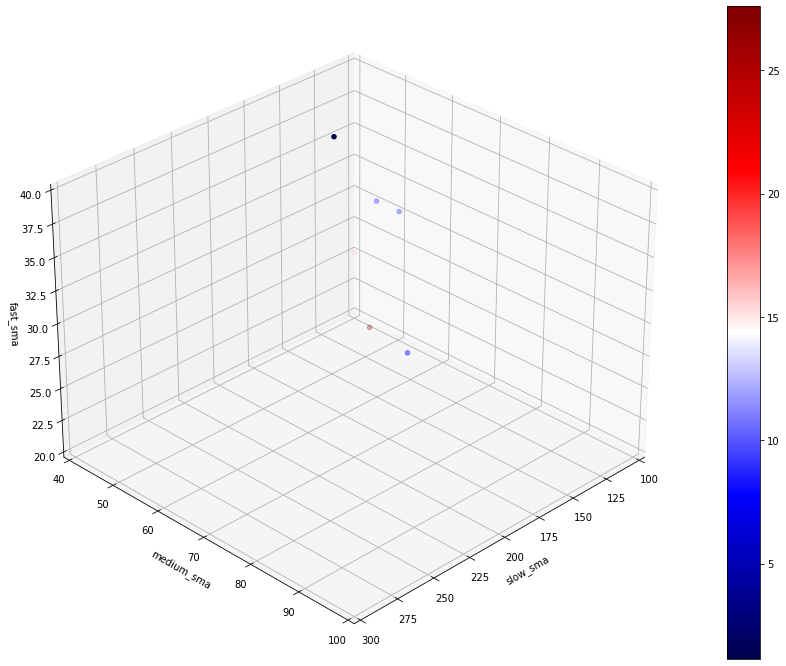

In [7]:
triple_sma_strategy.optimize_strategy(dataset)

### II. Buy and sell the next day ###
1. Buy the stock on the fourth day open, if the stock closes down consecutively for three days.
2. Exit on the next day open.
3. Optional: Optimise the strategy by exiting the long position on the same day close. Also, you can optimise the number of down days. There are high chances that the number of down days would be different for each stock.

In [8]:
# For this Trading Strategy we use vectorized backtesting

class BuySellNextDay():
    def __init__(self, df, number_of_days_down, exit_strategy, multiparallelism = False):
        self.data = df[["Adj Close", "Open"]].copy()
        self.days_down = number_of_days_down
        self.exit = exit_strategy
        self.mp = multiparallelism
        self.compute_indicators()
        self.signals(self.days_down)
        self.positions()
    
    def compute_indicators(self):
        """ 
        This method builds a number of columns equal to the number of days down required
        to compute the signal by respectively shifting the "Adj Close" by the "ddown" for loop variable
        """
        for ddown in range(self.days_down):
            self.data["prev_day" + str(ddown + 1)] = self.data["Adj Close"].shift(ddown + 1)
            
        #print(f"shape before deleting NaN values: {self.data.shape}")
        self.data.dropna(inplace=True)
        #print(f"shape after deleting NaN values: {self.data.shape}")
        #print(self.data.head())
    
    def signals(self, days_down, first= True):
        """ 
        This method calulates the signal recursively based on the required number of days
        for which we want the "Adj Close" to close down consecutively
        """
        #print("-"* 60)
        #print(days_down)
        #print(type(days_down))
        #print("-"* 60)
        
        # base case for recursion: exit when indicator reaches zero
        if days_down == 0:
            #print(self.data.head(20))
            print(self.data['signal'].value_counts())
            #print()
            #print(self.data.loc[self.data['signal'] == 1])
            return
        
        # long position enter signal
        else:
            # handle the case when numb_of_days_down is set to 1
            if first and days_down == 1:
                self.data['signal'] = np.where( (self.data['Adj Close'] \
                                                < self.data["prev_day" + str(days_down)]), 1, 0)
            elif days_down == self.days_down:
                self.data['signal'] = np.where( (self.data["prev_day" + str(days_down - 1)] \
                                                < self.data["prev_day" + str(days_down)]), 1, 0)
            elif days_down == 1:
                self.data['signal'] = np.where( (self.data['Adj Close'] < self.data["prev_day" + str(days_down)])
                                               & (self.data["signal"] == 1), 1, 0)    
            else:
                self.data['signal'] = np.where( (self.data["prev_day" + str(days_down - 1)] \
                                                < self.data["prev_day" + str(days_down)]) \
                                                & (self.data["signal"] == 1), 1, 0)
            days_down -= 1
            return self.signals(days_down, first= False)
        
    def positions(self):
        '''
        The function computes the positions
        '''
        self.data['position'] = self.data['signal']
    
    def returns(self):
        '''
        The function computes simple returns and cumulated ones for the Buy&Hold Strategy 
        and "The next day "Buy&Sell" ones
        '''
        self.data['buy_and_hold'] = self.data['Adj Close'].pct_change()
        
        # "next day open" implies to shift one day for entering the position and another day for exiting the position when we realize the return
        if self.exit == "next_day_open":
            self.data['strategy_returns'] = self.data['Open'].pct_change() * self.data['position'].shift(2)
        
         # "same day close" implies to shift one day for entering the position at the Open of the next day the arrival of the signal
        # and exiting the position at the Close of the same day or (realistically one minute before market closes)
        elif self.exit == "same_day_close":
             self.data['strategy_returns'] = ((self.data["Adj Close"] - self.data["Open"]) / self.data["Open"]) * self.data['position'].shift(1)
        else:
            print("error in specifying the exit strategy")
        
        # when doimg optimization through MultiProcessing we do not need to print info
        if not self.mp:
            print("\n")
            print("-" * 60)
            print(f"Num. of days down: {self.days_down}, Exit: {self.exit}")
            print(f"Buy&Hold returns (simple): {((1 + self.data['buy_and_hold']).cumprod()[-1] -1) * 100:.2f}%")
            print(f"Strategy returns (simple): {((1 + self.data['strategy_returns']).cumprod()[-1] -1) * 100:.2f}%")
            #print(self.data.head(20))
        
        else:
            buy_and_hold_return = ((1 + self.data['buy_and_hold']).cumprod()[-1] -1) * 100
            strategy_return = ((1 + self.data['strategy_returns']).cumprod()[-1] -1) * 100     
            
            return (self.days_down, self.exit, buy_and_hold_return, strategy_return)
        
        
    def analysis(self):
        '''
        The function checks whether positions are generated properly and compares returns of Buy&Hold Strategy 
        and the Strategy using plots
        '''
        # A plot to check if the strategy is working as planned:
        self.data[["Adj Close", "Open", 'position']].plot(figsize=(20, 12), secondary_y='position', grid=True);
        plt.title('checking if positions are generated properly')
        plt.show()
        
        # A plot to check how the strategy strategy performs relative to buy & hold
        self.data['buy_and_hold'] = 1 + self.data['buy_and_hold']
        self.data['strategy_returns'] = 1 + self.data['strategy_returns']
        self.data[['buy_and_hold','strategy_returns']].cumprod().plot(figsize=(15, 6), grid=True)
        plt.title("Buy & Hold' vs 'strategy_returns' cumulative returns")
        plt.show()
        
        # General analytics
        pf.create_full_tear_sheet(self.data["strategy_returns"] -1, benchmark_rets=None)
    
    
    def optimize_strategy(self, raw_data):
        '''
        The function uses multiprocessing (this is a CPU-bound job) to optimize in parallel different combuinations
        of parameters: numb.of days down and different exit strategies.
        '''
        
        # grid-search with brute force using multi-processing
        exit = ["next_day_open", "same_day_close"]
        days_down = [1, 6]
        step_size = 1
        
        days_down_range = list(np.arange(days_down[0], days_down[1], step_size))
        param_combinations = list(product(*[days_down_range, exit])) 
        #print(param_combinations)
            
        prepared_list = []
        for i in range(len(param_combinations)):
            prepared_list.append((raw_data, param_combinations[i][0], param_combinations[i][1], True))
            #print([param_combinations[i][0], param_combinations[i][1]])

        start_time = time()
        # I've got 16 CPU on my PC
        print(f"num of cpus being used: {max(1, cpu_count() - 1)}")
        with Pool(processes = max(1, cpu_count() - 1)) as mp_pool:
            results = mp_pool.starmap(BuySellNextDay, prepared_list)
            
        num_of_days_down_list = []
        exit_list = []
        buy_and_hod_returns = []
        strategy_returns = []
        
        for res in results:
            v = res.returns()
            #print(v)
            num_of_days_down_list.append(v[0]), exit_list.append(v[1])
            buy_and_hod_returns.append(v[2]), strategy_returns.append(v[3])
            
        # Convert into a DataFrame
        df_results = pd.DataFrame({'num_of_days_down':num_of_days_down_list, 'exit': exit_list, \
                                   'strategy_returns': strategy_returns})
        print(df_results.head(10).sort_values(by= 'strategy_returns', ascending=False))
        print()
        print(df_results.describe())
       
        
        print(f"\nEverything took {(time() -  start_time):.2f} sec. to complete")

In [9]:
dataset =raw_data.copy()
number_of_days_down = 3
exit_strategy = "next_day_open" # options: "same_day_close", "next_day_open"
buysellnextday = BuySellNextDay(dataset, number_of_days_down, exit_strategy)

0    555
1     50
Name: signal, dtype: int64


In [10]:
buysellnextday.returns()



------------------------------------------------------------
Num. of days down: 3, Exit: next_day_open
Buy&Hold returns (simple): 18.83%
Strategy returns (simple): 1.34%


In [11]:
# Compute different metrics the strategy using pyfolio
#buysellnextday.analysis()

In [12]:
buysellnextday.optimize_strategy(dataset)

num of cpus being used: 15
0    335
1    272
Name: signal, dtype: int640    493
1    113
Name: signal, dtype: int640    585
1     19
Name: signal, dtype: int640    335
1    272
Name: signal, dtype: int64



0    493
1    113
Name: signal, dtype: int640    555
1     50
Name: signal, dtype: int640    585
1     19
Name: signal, dtype: int64

0    555
1     50
Name: signal, dtype: int64
0    596
1      7
Name: signal, dtype: int640    596
1      7
Name: signal, dtype: int64


   num_of_days_down            exit  strategy_returns
2                 2   next_day_open          3.921313
6                 4   next_day_open          3.831441
4                 3   next_day_open          1.342286
8                 5   next_day_open          0.688339
0                 1   next_day_open         -2.205026
9                 5  same_day_close        -11.591938
7                 4  same_day_close        -23.119657
5                 3  same_day_close        -52.751032
3                 2  same_day_close  

### Strategy based on RSI indicator ###
1. Buy the instrument such as Nifty or SPY when the RSI is less than 15
2. Exit conditions: <br>
    a. Take profit of 5% or RSI > 75  <br>
    b. Stop loss of - 2%
3. Optional: Optimise the strategy by adjusting the RSI value. Also, take profit and stoploss criteria can be different for each stock.
4. Note: You can use TA-Lib in Python to compute the RSI value.

In [80]:
asset= "SPY"
start_date = datetime(2018, 1, 1)
end_date = datetime(2020, 3, 31)
raw_data = download_data(asset, start_date, end_date)

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close     Volume
Date                                                                             
2020-03-24  234.419998  244.100006  233.800003  243.149994  235.187958  235494500
2020-03-25  244.869995  256.350006  239.750000  246.789993  238.708786  299430300
2020-03-26  249.520004  262.799988  249.050003  261.200012  252.646942  257632800
2020-03-27  253.270004  260.809998  251.050003  253.419998  245.121658  224341200
2020-03-30  255.699997  262.429993  253.529999  261.649994  253.082138  171369500
(564, 6)
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
shape with NaN values: (564, 6)
shape after deleting NaN values: (564, 6)


In [89]:
# For this Trading Strategy we use event-based backtesting

class RSI_Strategy():
    def __init__(self, df, buy_rsi, tp_rsi, take_profit, stop_loss, multiparallelism = False):
        self.data = df[["Adj Close"]].copy()
        self.buy_rsi = buy_rsi
        self.tp_rsi = tp_rsi
        self.take_profit = take_profit
        self.stop_loss = stop_loss
        self.mp = multiparallelism
        self.trades = 0
        self.position = 0
        self.starting_price = None
        
        self.prepare_statistics()
        self.backtest_strategy()
        self.returns()
        self.analysis()
    
    def get_date_price(self, bar):
        '''
        This method generates date and price for a specific bar
        '''
        date, price  = str(self.data.index[bar])[:10], self.data["Adj Close"].iloc[bar]
        return date, price
    
    def place_buy_order(self, bar):
        '''
        This method place a buy order ans set open_position to 1 so that only one buy order can be open
        at the same time
        '''
        date, price = self.get_date_price(bar)
        self.trades += 1
        self.position = 1
        self.starting_price = price
        self.data["signal"].iloc[bar] = 1
        if not self.mp:
            print(f"{date} | bought 1 unit for price: {price}")
    
    def close_out(self, bar):
        '''
        This method squares off a buy order and sets open_position to 0 so that a new buy order can be opened
        if conditions are met
        '''
        date, price = self.get_date_price(bar)
        self.position = 0
        self.data["strategy_returns"].iloc[bar] = (price - self.starting_price) / self.starting_price
        self.data["signal"].iloc[bar] = 0
        if not self.mp:
            print(f"{date} | closing out buy order at price: {price}")
    
    def prepare_statistics(self):
        """ 
        This method builds a number of columns required to compute the signals to enter/exit the position
        """
        self.data["rsi"] = RSI(self.data["Adj Close"])
        # empty columns used for ex-post analysis 
        self.data["strategy_returns"] = 0
        self.data["signal"] = -1
        #print(self.data)
    
    def backtest_strategy(self):
        """ 
        This method builds backtest the strategy in ana event-driven fashion
        """
        # we start from 14 since the standard RSI indicator is calculated based on the last 14 bars
        for bar in range(14, len(self.data)):
            date, price = self.get_date_price(bar)
            
            # check if exit conditions are met:
            if self.position == 1:
                take_profit1 = ((price - self.starting_price) / self.starting_price) * 100 >=  self.take_profit
                take_profit2 = self.data["rsi"].iloc[bar] >= self.tp_rsi
                stop_loss = ((price - self.starting_price) / self.starting_price) * 100 <=  self.stop_loss
            
            # square off position if conditions are met
            if self.position == 1 and (take_profit1 or take_profit2 or stop_loss):
                self.close_out(bar)
            
            # enter long position if no position is already open and RSI satisfies our condition
            if self.position == 0 and self.data["rsi"].iloc[bar] < self.buy_rsi:
                self.place_buy_order(bar)
        
        # close position just in case on the last bar there is still an open trade:
        self.close_out(bar) if self.position == 1 else None
    
    def returns(self):
        '''
        The function computes simple returns and cumulated ones for the "Buy & Hold" Strategy 
        and "RSI Strategy" ones
        '''
        
        self.data["position"] = self.data["signal"].replace(to_replace= -1, method= "ffill")
        
        self.data['buy_and_hold'] = self.data['Adj Close'].pct_change()
        self.data['stretegy_returns'] = self.data['buy_and_hold'] * self.data["position"].shift(1)
        
        # when doimg optimization through MultiProcessing we do not need to print info
        if not self.mp:
            print("\n")
            print("-" * 60)
            print(f"RSI buy: {self.buy_rsi}, RSI TP: {self.tp_rsi}, TP: {self.take_profit}%, SL: {self.stop_loss}%")
            print(f"Buy & Hold returns (simple): {((1 + self.data['buy_and_hold']).cumprod()[-1] -1) * 100:.2f}%")
            print(f"Strategy returns (simple): {((1 + self.data['strategy_returns']).cumprod()[-1] -1) * 100:.2f}%")
            #print(self.data.head(20))
        
        else:
            buy_and_hold_return = ((1 + self.data['buy_and_hold']).cumprod()[-1] -1) * 100
            strategy_return = ((1 + self.data['strategy_returns']).cumprod()[-1] -1) * 100     
            
            return (self.days_down, self.exit, buy_and_hold_return, strategy_return)
        
    
    def analysis(self):
        '''
        The function checks whether positions are generated properly and compares returns of "Buy & Hold" Strategy 
        and the one in question using plots
        '''
        # A plot to check if the strategy is working as planned:
        self.data[["rsi",'position']].plot(figsize=(15, 10), secondary_y='position', grid=True);
        plt.title('checking if positions are generated properly')
        plt.show()
        
        # A plot to check how the strategy strategy performs relative to buy & hold
        self.data['buy_and_hold'] = 1 + self.data['buy_and_hold']
        self.data['strategy_returns'] = 1 + self.data['strategy_returns']
        self.data[['buy_and_hold','strategy_returns']].cumprod().plot(figsize=(15, 6), grid=True)
        plt.title("Buy & Hold' vs 'strategy_returns' cumulative returns")
        plt.show()
        
        # General analytics
        #pf.create_full_tear_sheet(self.data["strategy_returns"] -1, benchmark_rets=None)
    
    def optimize_strategy(self):
        pass

2018-10-11 | bought 1 unit for price: 255.36373901367188
2018-10-24 | closing out buy order at price: 248.9367218017578
2018-12-24 | bought 1 unit for price: 221.15365600585938
2018-12-26 | closing out buy order at price: 232.32740783691406
2020-02-27 | bought 1 unit for price: 286.0856628417969
2020-03-04 | closing out buy order at price: 300.8462219238281


------------------------------------------------------------
RSI buy: 21, RSI TP: 50, TP: 5%, SL: -2%
Buy & Hold returns (simple): 1.67%
Strategy returns (simple): 7.69%


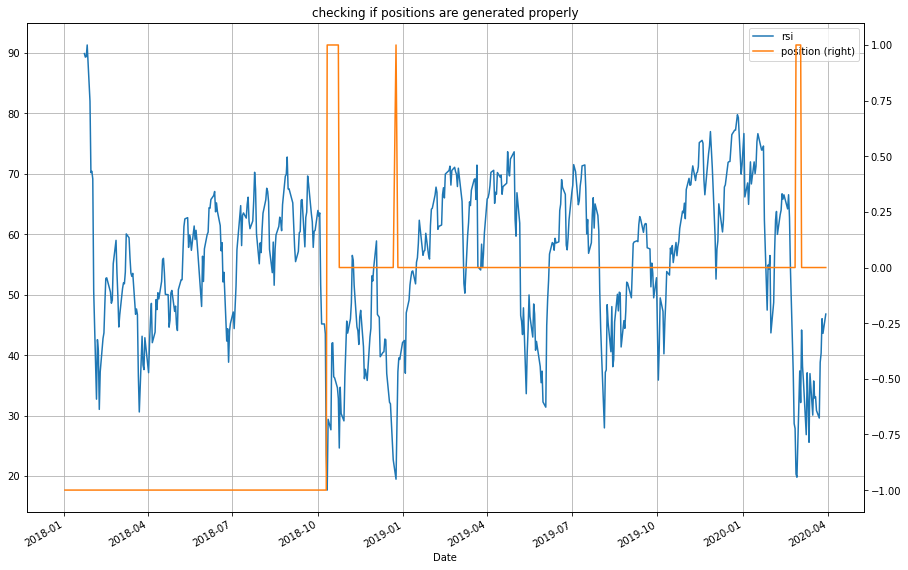

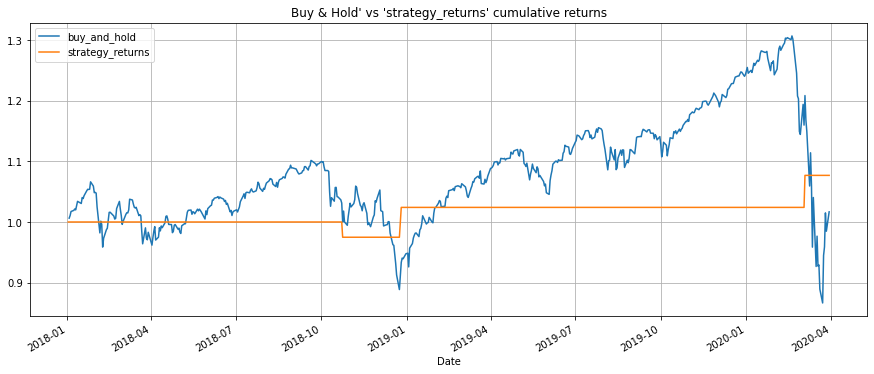

In [90]:
dataset =raw_data.copy()
buy_rsi = 21
tp_rsi = 50
take_profit_percent = 5
stop_loss_percent = -2
rsi_strategy = RSI_Strategy(dataset, buy_rsi, tp_rsi, take_profit_percent, stoploss_percent)